In [28]:
import numpy as np
import flopy
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt

In [91]:
# aquifer size


delx = 1
dely = 1
delz = 1

lambdax = 25
lambday = 25
lambdaz = 5

nlay = lambdaz*3
nrow = lambday*3
ncol = lambdax*6

ztop = 0.
zbot = np.zeros((nlay, nrow, ncol))
for i in range(nlay):
    zbot[i, :, :] = ztop - delz*(i+1)
    
# flow boundary condition

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
    
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = ncol
strt[:, :, -1] = 0

lrcq = {}
lrcq[0] = []
for i in range(lambdax,lambdax*2):
    for j in range(lambday,lambday*2):
        lrcq[0].append([nlay-1, j, i, 1.])

# contamination source

initial=np.zeros((nlay,nrow,ncol))
for i in range(lambdax,lambdax*2):
    for j in range(lambday,lambday*2):
        initial[nlay-1, j, i] = 1
# ssmdata = {}
# ssmdata[0] = []
# itype = flopy.mt3d.Mt3dSsm.itype_dict()
# for i in range(10,20):
#     for j in range(15,25):
#         ssmdata[0].append([nlay-1, j, i, 1, itype['WEL']])
        
tlim=50
times=np.linspace(0, tlim, num=151)

In [92]:
print(nlay, nrow, ncol)

15 75 150


In [93]:
#load SGeMS
sgems=np.loadtxt('aquifer', skiprows=1, delimiter=',')

#Reshape SGeMS data
aquifer=np.zeros((nlay,nrow,ncol))
aquifer=np.reshape(sgems.T,(nlay,nrow,ncol))
np.save('sgemsaquifer',aquifer)

In [108]:
hk = np.exp(aquifer)
#hk = np.ones((nlay, nrow, ncol))

In [109]:
# Aquifer name
modelname = 'aquifer'
        
# MODFLOW
mf = flopy.modflow.Modflow(modelname, exe_name='MF2005.1_12/bin/mf2005dbl' )
dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delx, delc=dely, top=ztop, botm=zbot, nper=1, perlen=tlim)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk)
wel = flopy.modflow.ModflowWel(mf, stress_period_data=lrcq)
oc = flopy.modflow.ModflowOc(mf)
pcg = flopy.modflow.ModflowPcg(mf)
lmt = flopy.modflow.ModflowLmt(mf, output_file_header='extended', output_file_format='formatted', output_file_name=modelname+".ftl")
mf.write_input()
success, buff = mf.run_model()


FloPy is using the following executable to run the model: MF2005.1_12/bin/mf2005dbl.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: aquifer.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/09/05 23:18:18

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/09/05 23:18:22
 Elapsed run time:  3.497 Seconds

  Normal termination of simulation


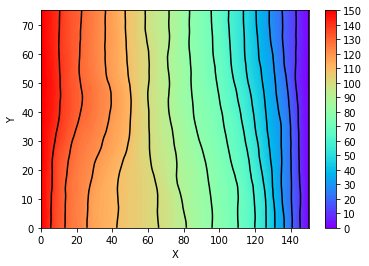

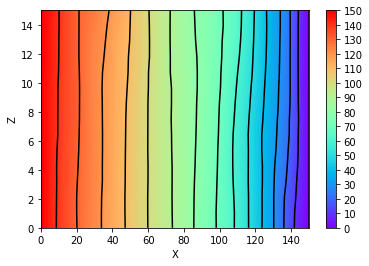

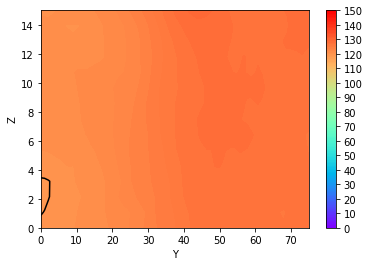

In [110]:
#Basic variables
Lx=(ncol)*delx
Ly=(nrow)*dely
Lz=(nlay)*delz
hg = ncol

levelh=np.arange(0,hg+1,1)
levelhl=np.arange(0,hg+1,10)
extent=(0., Lx, 0, Ly)
hds = bf.HeadFile('aquifer.hds')
head = hds.get_data(totim=tlim)

#plt.subplot(1,1,1,aspect='equal')
b=plt.contourf(head[-1,:,:], levels=levelh, extent=extent, cmap=plt.cm.rainbow)
plt.contour(head[-1,:,:], colors=('0'), levels=levelhl, extent=extent)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(b, ticks=levelhl, orientation='vertical')
plt.savefig('hh',dpi=400)
plt.show()

extent=(0., Lx, 0, Lz)
#plt.subplot(1,1,1,aspect='equal')
b=plt.contourf(head[:,int(nrow/2),:], levels=levelh, extent=extent, cmap=plt.cm.rainbow)
plt.contour(head[:,int(nrow/2),:], colors=('0'), levels=levelhl, extent=extent)
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar(b, ticks=levelhl, orientation='vertical')
plt.show()

extent=(0., Ly, 0, Lz)
#plt.subplot(1,1,1,aspect='equal')
b=plt.contourf(head[:,:,lambdax], levels=levelh, extent=extent, cmap=plt.cm.rainbow)
plt.contour(head[:,:,lambdax], colors=('0'), levels=levelhl, extent=extent)
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar(b, ticks=levelhl, orientation='vertical')
plt.show()

In [111]:
f = open('aquifer.ftl', 'r')
cell_number = nlay * nrow * ncol
velocity_vector = np.zeros((cell_number,3))

for line in f:
    if line[3] == 'X':
        print(line)
        itera = 0
        for i in range(int(cell_number/3)):
            subline = f.readline().split()
#             print(type(subline), subline)
            for j in range(3):
                velocity_vector[itera, 0] = float(subline[j])
                itera += 1

    if line[3] == 'Y':
        print(line)
        itera = 0
        for i in range(int(cell_number/3)):
            subline = f.readline().split()
#             print(type(subline), subline)
            for j in range(3):
                velocity_vector[itera, 1] = float(subline[j])
                itera += 1

    if line[3] == 'Z':
        print(line)
        itera = 0
        for i in range(int(cell_number/3)):
            subline = f.readline().split()
#             print(type(subline), subline)
            for j in range(3):
                velocity_vector[itera, 2] = float(subline[j])
                itera += 1
        
f.close()

 'QXX             '

 'QYY             '

 'QZZ             '



In [112]:
import pyvista as pv

In [113]:
vgrid = np.zeros((cell_number, 3))
iteration = 0
deltal = 1
for l in range(nlay):
    for k in range(nrow):
        for j in range(ncol):
            vgrid[iteration] = np.array(([j*deltal,k*deltal,l*deltal]))
            iteration += 1            

In [114]:
np.max(velocity_vector)

27.0719046886014

In [115]:
mt = flopy.mt3d.Mt3dms(modflowmodel=mf, modelname=modelname, namefile_ext='mtnam',
                       exe_name='mt3dms5/bin/mt3dms5b', ftlfree=True, ftlfilename=modelname+".ftl")
btn=flopy.mt3d.Mt3dBtn(mt,prsity=0.4, sconc=initial, ncomp=1, nprs=1, timprs=times, savucn=True)
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=3, percel=0.75, mxpart=8000000)
dsp = flopy.mt3d.Mt3dDsp(mt, al=0.01, trpt=0.1, trpv=0.01, dmcoef=1e-9)
rct = flopy.mt3d.Mt3dRct(mt,isothm=0, igetsc=0)
ssm = flopy.mt3d.Mt3dSsm(mt)
gcg = flopy.mt3d.Mt3dGcg(mt)
mt.write_input()
success, buff=mt.run_model()

FloPy is using the following executable to run the model: mt3dms5/bin/mt3dms5b.exe
MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]
Developed at University of Alabama for U.S. Department of Defense

Using NAME File: aquifer.mtnam                                     

STRESS PERIOD NO.    1

TIME STEP NO.    1
FROM TIME =   0.0000     TO    50.000    

Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
Transport Step:    2   Step Size:  1.1356E-02 Total Elapsed Time:  1.13560E-02
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2869E-01  [K,I,J]   15   27   26
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5960E-07  [K,I,J]   15   26   26
Transport Step:    3   Step Size:  1.1356E-02 Total Elapsed Time:  2.27119E-02
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2863E-01  [K,I,J]   15   30   50
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5960E-07  [K,I,J]   15   26   26
Transport Step:    4   Step Size:  1.1356E-02 Total Elapsed Time:  3.40679E-

Transport Step:   35   Step Size:  1.1356E-02 Total Elapsed Time:  0.37875    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1426E-01  [K,I,J]   15   31   28
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1630E-08  [K,I,J]   14   23   35
Transport Step:   36   Step Size:  1.1356E-02 Total Elapsed Time:  0.39011    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1428E-01  [K,I,J]   15   31   28
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7451E-08  [K,I,J]   15   26   29
Transport Step:   37   Step Size:  1.1356E-02 Total Elapsed Time:  0.40147    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1387E-01  [K,I,J]   15   28   30
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1630E-08  [K,I,J]   14   22   35
Transport Step:   38   Step Size:  1.1356E-02 Total Elapsed Time:  0.41282    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1333E-01  [K,I,J]   15   28   30
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2095E-08  [K,I,J]   14   22   35
Transport Step:   39   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]   13   17   43
Transport Step:   87   Step Size:  1.1356E-02 Total Elapsed Time:  0.96193    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4511E-02  [K,I,J]   15   43   29
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]   13   17   46
Transport Step:   88   Step Size:  1.1356E-02 Total Elapsed Time:  0.97328    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4498E-02  [K,I,J]   15   43   29
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   13   16   44
Transport Step:   89   Step Size:  1.1356E-02 Total Elapsed Time:  0.98464    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4463E-02  [K,I,J]   15   43   29
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]   13   17   45
Transport Step:   90   Step Size:  1.1356E-02 Total Elapsed Time:  0.99599    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4394E-02  [K,I,J]   15   38   29
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7091E-03  [K,I,J]   15   45   29
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1819E-11  [K,I,J]   14   17   57
Transport Step:  122   Step Size:  1.1356E-02 Total Elapsed Time:   1.3447    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1879E-02  [K,I,J]   15   45   29
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   13   17   47
Transport Step:  123   Step Size:  1.1356E-02 Total Elapsed Time:   1.3560    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1795E-02  [K,I,J]   15   45   29
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3725E-08  [K,I,J]   13   18   45
Transport Step:  124   Step Size:  1.1356E-02 Total Elapsed Time:   1.3674    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1793E-02  [K,I,J]   15   45   29
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   13   17   48
Transport Step:  125   Step Size:  1.1356E-02 Total Elapsed Time:   1.3787    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1731E-

Transport Step:  173   Step Size:  1.1356E-02 Total Elapsed Time:   1.9165    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7465E-03  [K,I,J]   12   45   57
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-09  [K,I,J]   14   16   57
Transport Step:  174   Step Size:  1.1356E-02 Total Elapsed Time:   1.9279    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9776E-03  [K,I,J]   12   45   57
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   14   20   59
Transport Step:  175   Step Size:  1.1356E-02 Total Elapsed Time:   1.9392    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9241E-03  [K,I,J]   12   45   57
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   13   18   51
Transport Step:  176   Step Size:  1.1356E-02 Total Elapsed Time:   1.9506    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9124E-03  [K,I,J]   12   45   57
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   14   16   54
Transport Step:  177   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   14   16   56
Transport Step:  208   Step Size:  1.1356E-02 Total Elapsed Time:   2.3066    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1029E-02  [K,I,J]   14   17   55
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]   14   20   60
Transport Step:  209   Step Size:  1.1356E-02 Total Elapsed Time:   2.3180    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9007E-03  [K,I,J]   14   21   59
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   14   22   66
Transport Step:  210   Step Size:  1.1356E-02 Total Elapsed Time:   2.3293    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9338E-03  [K,I,J]   14   21   60
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   13   19   48
Transport Step:  211   Step Size:  3.9797E-03 Total Elapsed Time:   2.3333    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3282E-03  [K,I,J]   14   21   59
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1819E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1279E-02  [K,I,J]   15   17   59
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   10   19   62
Transport Step:  243   Step Size:  1.1356E-02 Total Elapsed Time:   2.6894    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1368E-02  [K,I,J]   15   17   59
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   15   16   60
Transport Step:  244   Step Size:  1.1356E-02 Total Elapsed Time:   2.7008    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1516E-02  [K,I,J]   14   23   65
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   14   17   56
Transport Step:  245   Step Size:  1.1356E-02 Total Elapsed Time:   2.7121    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1559E-02  [K,I,J]   14   23   65
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   14   17   58
Transport Step:  246   Step Size:  1.1356E-02 Total Elapsed Time:   2.7235    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1358E-

Transport Step:  294   Step Size:  1.1356E-02 Total Elapsed Time:   3.2612    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1586E-02  [K,I,J]   15   35   87
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]   15   36   86
Transport Step:  295   Step Size:  1.1356E-02 Total Elapsed Time:   3.2725    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1194E-02  [K,I,J]   15   35   87
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]   15   36   86
Transport Step:  296   Step Size:  1.1356E-02 Total Elapsed Time:   3.2839    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1430E-02  [K,I,J]   11   28   65
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   10   19   58
Transport Step:  297   Step Size:  1.1356E-02 Total Elapsed Time:   3.2953    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1325E-02  [K,I,J]   11   28   65
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   10   21   65
Transport Step:  298   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   10   21   64
Transport Step:  329   Step Size:  1.1356E-02 Total Elapsed Time:   3.6513    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1410E-02  [K,I,J]   15   37   90
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   10   21   64
Transport Step:  330   Step Size:  1.1356E-02 Total Elapsed Time:   3.6626    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1544E-02  [K,I,J]   15   37   94
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   10   21   64
Transport Step:  331   Step Size:  4.0793E-03 Total Elapsed Time:   3.6667    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7778E-03  [K,I,J]   15   37   94
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   19   62
Transport Step:  332   Step Size:  1.1356E-02 Total Elapsed Time:   3.6781    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1265E-02  [K,I,J]   15   36   88
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6985E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1521E-02  [K,I,J]   11   30   75
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   11   23   79
Transport Step:  364   Step Size:  1.1356E-02 Total Elapsed Time:   4.0341    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1136E-02  [K,I,J]   12   27   82
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   11   23   79
Transport Step:  365   Step Size:  1.1356E-02 Total Elapsed Time:   4.0454    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1269E-02  [K,I,J]   15   36   93
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   10   22   65
Transport Step:  366   Step Size:  1.1356E-02 Total Elapsed Time:   4.0568    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1467E-02  [K,I,J]   12   26   80
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   12   23   76
Transport Step:  367   Step Size:  1.1356E-02 Total Elapsed Time:   4.0681    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1462E-

Transport Step:  415   Step Size:  1.1356E-02 Total Elapsed Time:   4.6058    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1062E-02  [K,I,J]   15   35   93
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   10   22   64
Transport Step:  416   Step Size:  1.1356E-02 Total Elapsed Time:   4.6172    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1783E-02  [K,I,J]   11   30   80
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   11   25   83
Transport Step:  417   Step Size:  1.1356E-02 Total Elapsed Time:   4.6286    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1461E-02  [K,I,J]   11   30   80
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   15   43  106
Transport Step:  418   Step Size:  1.1356E-02 Total Elapsed Time:   4.6399    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1247E-02  [K,I,J]   15   38  102
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   14   26   94
Transport Step:  419   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   11   24   79
Transport Step:  450   Step Size:  1.1356E-02 Total Elapsed Time:   4.9960    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1259E-02  [K,I,J]   15   42  107
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   12   25   81
Transport Step:  451   Step Size:  3.9797E-03 Total Elapsed Time:   5.0000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4763E-03  [K,I,J]   15   42  107
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   14   21   86
Transport Step:  452   Step Size:  1.1356E-02 Total Elapsed Time:   5.0114    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8467E-03  [K,I,J]   15   36   98
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]   13   25   72
Transport Step:  453   Step Size:  1.1356E-02 Total Elapsed Time:   5.0227    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1059E-02  [K,I,J]   14   33   97
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1324E-02  [K,I,J]   15   44  112
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   14   31  107
Transport Step:  485   Step Size:  1.1356E-02 Total Elapsed Time:   5.3787    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1158E-02  [K,I,J]   14   35  105
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   12   26   82
Transport Step:  486   Step Size:  1.1356E-02 Total Elapsed Time:   5.3901    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8422E-03  [K,I,J]   15   26   82
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]   15   44   92
Transport Step:  487   Step Size:  1.1356E-02 Total Elapsed Time:   5.4014    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9993E-03  [K,I,J]   12   29   79
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   15   44   93
Transport Step:  488   Step Size:  1.1356E-02 Total Elapsed Time:   5.4128    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1093E-

Transport Step:  536   Step Size:  1.1356E-02 Total Elapsed Time:   5.9506    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8729E-03  [K,I,J]   15   41   89
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]   15   24   90
Transport Step:  537   Step Size:  1.1356E-02 Total Elapsed Time:   5.9620    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1283E-02  [K,I,J]   15   33   95
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]   12   26   81
Transport Step:  538   Step Size:  1.1356E-02 Total Elapsed Time:   5.9733    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1430E-02  [K,I,J]   15   28   88
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]   15   44   90
Transport Step:  539   Step Size:  1.1356E-02 Total Elapsed Time:   5.9847    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1082E-02  [K,I,J]   15   28   88
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]   15   24   90
Transport Step:  540   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]    8   45  125
Transport Step:  571   Step Size:  3.9797E-03 Total Elapsed Time:   6.3333    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4435E-03  [K,I,J]   15   30   94
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1421E-13  [K,I,J]    6   47  128
Transport Step:  572   Step Size:  1.1356E-02 Total Elapsed Time:   6.3447    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1260E-02  [K,I,J]   10   45   80
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   12   26   81
Transport Step:  573   Step Size:  1.1356E-02 Total Elapsed Time:   6.3560    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1161E-02  [K,I,J]   15   45  107
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   12   26   81
Transport Step:  574   Step Size:  1.1356E-02 Total Elapsed Time:   6.3674    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9540E-03  [K,I,J]   15   42   86
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9196E-03  [K,I,J]   15   42   88
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   14   35  103
Transport Step:  606   Step Size:  1.1356E-02 Total Elapsed Time:   6.7235    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8086E-03  [K,I,J]   15   43   93
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   14   35   99
Transport Step:  607   Step Size:  1.1356E-02 Total Elapsed Time:   6.7348    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7006E-03  [K,I,J]   15   46  106
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   14   38   97
Transport Step:  608   Step Size:  1.1356E-02 Total Elapsed Time:   6.7462    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7639E-03  [K,I,J]   15   43   91
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   14   38   97
Transport Step:  609   Step Size:  1.1356E-02 Total Elapsed Time:   6.7575    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7703E-

Transport Step:  657   Step Size:  1.1356E-02 Total Elapsed Time:   7.2953    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7027E-03  [K,I,J]   15   39  115
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    8   55  122
Transport Step:  658   Step Size:  1.1356E-02 Total Elapsed Time:   7.3066    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1078E-02  [K,I,J]    9   41  113
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    9   50  129
Transport Step:  659   Step Size:  1.1356E-02 Total Elapsed Time:   7.3180    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1301E-02  [K,I,J]    9   41  112
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    8   52  115
Transport Step:  660   Step Size:  1.1356E-02 Total Elapsed Time:   7.3293    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1281E-02  [K,I,J]    9   41  112
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   13   36  104
Transport Step:  661   Step Size:  3.9797E-03 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   14   55  114
Transport Step:  692   Step Size:  1.1356E-02 Total Elapsed Time:   7.6781    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1025E-02  [K,I,J]    8   42  123
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    8   54  122
Transport Step:  693   Step Size:  1.1356E-02 Total Elapsed Time:   7.6894    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1013E-02  [K,I,J]    8   42  123
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    8   55  122
Transport Step:  694   Step Size:  1.1356E-02 Total Elapsed Time:   7.7008    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7500E-03  [K,I,J]    9   41  119
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]    8   56  125
Transport Step:  695   Step Size:  1.1356E-02 Total Elapsed Time:   7.7121    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9830E-03  [K,I,J]    8   43  120
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9166E-03  [K,I,J]    8   46  118
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3725E-08  [K,I,J]    8   55  123
Transport Step:  744   Step Size:  1.1356E-02 Total Elapsed Time:   8.2612    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1143E-02  [K,I,J]    8   46  118
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3725E-08  [K,I,J]    8   55  124
Transport Step:  745   Step Size:  1.1356E-02 Total Elapsed Time:   8.2726    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1223E-02  [K,I,J]   10   45  108
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]    9   52  135
Transport Step:  746   Step Size:  1.1356E-02 Total Elapsed Time:   8.2839    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1117E-02  [K,I,J]    8   42  123
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]    8   57  123
Transport Step:  747   Step Size:  1.1356E-02 Total Elapsed Time:   8.2953    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1418E-

Transport Step:  778   Step Size:  1.1356E-02 Total Elapsed Time:   8.6399    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1411E-02  [K,I,J]    7   45  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    8   59  125
Transport Step:  779   Step Size:  1.1356E-02 Total Elapsed Time:   8.6513    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1468E-02  [K,I,J]    7   45  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]    9   52  132
Transport Step:  780   Step Size:  1.1356E-02 Total Elapsed Time:   8.6626    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1217E-02  [K,I,J]    7   44  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7451E-08  [K,I,J]    8   55  123
Transport Step:  781   Step Size:  4.0665E-03 Total Elapsed Time:   8.6667    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4718E-03  [K,I,J]    7   44  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9095E-12  [K,I,J]   10   53  125
Transport Step:  782   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    7   39  137
Transport Step:  813   Step Size:  1.1356E-02 Total Elapsed Time:   9.0227    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1354E-02  [K,I,J]    8   48  118
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    7   39  137
Transport Step:  814   Step Size:  1.1356E-02 Total Elapsed Time:   9.0341    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1499E-02  [K,I,J]    9   48  126
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]   14   41   98
Transport Step:  815   Step Size:  1.1356E-02 Total Elapsed Time:   9.0454    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1115E-02  [K,I,J]    8   52  116
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    7   39  138
Transport Step:  816   Step Size:  1.1356E-02 Total Elapsed Time:   9.0568    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1243E-02  [K,I,J]    8   48  119
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9499E-03  [K,I,J]    8   45  136
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]    7   39  138
Transport Step:  865   Step Size:  1.1356E-02 Total Elapsed Time:   9.6059    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1144E-02  [K,I,J]    8   50  119
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    8   40  141
Transport Step:  866   Step Size:  1.1356E-02 Total Elapsed Time:   9.6172    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1022E-02  [K,I,J]    8   50  119
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    9   42  127
Transport Step:  867   Step Size:  1.1356E-02 Total Elapsed Time:   9.6286    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8797E-03  [K,I,J]    8   48  127
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]    8   40  141
Transport Step:  868   Step Size:  1.1356E-02 Total Elapsed Time:   9.6399    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1028E-

Transport Step:  899   Step Size:  1.1356E-02 Total Elapsed Time:   9.9847    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9587E-03  [K,I,J]    7   46  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]   10   53  136
Transport Step:  900   Step Size:  1.1356E-02 Total Elapsed Time:   9.9960    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9414E-03  [K,I,J]    9   51  136
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]   13   49   99
Transport Step:  901   Step Size:  3.9654E-03 Total Elapsed Time:   10.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3212E-03  [K,I,J]    9   51  136
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3553E-14  [K,I,J]   12   57  127
Transport Step:  902   Step Size:  1.1356E-02 Total Elapsed Time:   10.011    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8674E-03  [K,I,J]    9   52  134
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]    7   39  138
Transport Step:  903   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   11   58  145
Transport Step:  934   Step Size:  1.1356E-02 Total Elapsed Time:   10.367    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8361E-03  [K,I,J]    8   55  121
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]    7   39  138
Transport Step:  935   Step Size:  1.1356E-02 Total Elapsed Time:   10.378    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1102E-02  [K,I,J]    8   53  115
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   13   51   98
Transport Step:  936   Step Size:  1.1356E-02 Total Elapsed Time:   10.390    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1064E-02  [K,I,J]    8   51  115
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]    7   38  130
Transport Step:  937   Step Size:  1.1356E-02 Total Elapsed Time:   10.401    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1197E-02  [K,I,J]    9   53  125
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7092E-03  [K,I,J]    8   55  122
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   14   42   99
Transport Step:  986   Step Size:  1.1356E-02 Total Elapsed Time:   10.951    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7421E-03  [K,I,J]    7   51  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]    8   57  124
Transport Step:  987   Step Size:  1.1356E-02 Total Elapsed Time:   10.962    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7938E-03  [K,I,J]    9   52  134
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   11   53  144
Transport Step:  988   Step Size:  1.1356E-02 Total Elapsed Time:   10.974    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9805E-03  [K,I,J]    9   53  126
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7451E-08  [K,I,J]    9   52  135
Transport Step:  989   Step Size:  1.1356E-02 Total Elapsed Time:   10.985    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6043E-

Transport Step: 1020   Step Size:  1.1356E-02 Total Elapsed Time:   11.329    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1064E-02  [K,I,J]    9   52  131
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3725E-08  [K,I,J]    8   54  122
Transport Step: 1021   Step Size:  3.6659E-03 Total Elapsed Time:   11.333    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4263E-03  [K,I,J]    9   53  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3553E-14  [K,I,J]   12   56  138
Transport Step: 1022   Step Size:  1.1356E-02 Total Elapsed Time:   11.344    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8660E-03  [K,I,J]    9   53  135
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    8   51  117
Transport Step: 1023   Step Size:  1.1356E-02 Total Elapsed Time:   11.356    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1190E-02  [K,I,J]    9   52  132
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]    7   43  138
Transport Step: 1024   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]    9   51  136
Transport Step: 1055   Step Size:  1.1356E-02 Total Elapsed Time:   11.712    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9489E-03  [K,I,J]    9   52  126
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    9   49  130
Transport Step: 1056   Step Size:  1.1356E-02 Total Elapsed Time:   11.724    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1078E-02  [K,I,J]    9   53  131
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7451E-08  [K,I,J]    9   52  136
Transport Step: 1057   Step Size:  1.1356E-02 Total Elapsed Time:   11.735    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7492E-03  [K,I,J]    9   51  123
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    9   50  134
Transport Step: 1058   Step Size:  1.1356E-02 Total Elapsed Time:   11.746    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8717E-03  [K,I,J]    9   52  127
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7451E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6234E-03  [K,I,J]   10   50  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    8   57  123
Transport Step: 1107   Step Size:  1.1356E-02 Total Elapsed Time:   12.295    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7336E-03  [K,I,J]   10   51  146
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    9   57  133
Transport Step: 1108   Step Size:  1.1356E-02 Total Elapsed Time:   12.307    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6903E-03  [K,I,J]   10   51  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    8   57  124
Transport Step: 1109   Step Size:  1.1356E-02 Total Elapsed Time:   12.318    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9916E-03  [K,I,J]   10   50  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    8   57  125
Transport Step: 1110   Step Size:  1.1356E-02 Total Elapsed Time:   12.329    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1020E-

Transport Step: 1141   Step Size:  4.6654E-03 Total Elapsed Time:   12.667    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3109E-03  [K,I,J]   10   54  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   14   50  145
Transport Step: 1142   Step Size:  1.1356E-02 Total Elapsed Time:   12.678    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6294E-03  [K,I,J]   10   54  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3725E-08  [K,I,J]    9   52  135
Transport Step: 1143   Step Size:  1.1356E-02 Total Elapsed Time:   12.690    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5547E-03  [K,I,J]   10   53  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3725E-08  [K,I,J]    9   52  136
Transport Step: 1144   Step Size:  1.1356E-02 Total Elapsed Time:   12.701    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6696E-03  [K,I,J]   10   53  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]    8   52  119
Transport Step: 1145   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3725E-08  [K,I,J]    9   52  136
Transport Step: 1176   Step Size:  1.1356E-02 Total Elapsed Time:   13.057    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7908E-03  [K,I,J]    9   53  124
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    9   51  136
Transport Step: 1177   Step Size:  1.1356E-02 Total Elapsed Time:   13.068    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8014E-03  [K,I,J]   10   53  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]    8   55  121
Transport Step: 1178   Step Size:  1.1356E-02 Total Elapsed Time:   13.079    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8751E-03  [K,I,J]   10   53  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    9   51  136
Transport Step: 1179   Step Size:  1.1356E-02 Total Elapsed Time:   13.091    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7802E-03  [K,I,J]   10   53  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7675E-03  [K,I,J]   10   54  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]    9   50  130
Transport Step: 1228   Step Size:  1.1356E-02 Total Elapsed Time:   13.640    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6724E-03  [K,I,J]   10   54  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    9   51  131
Transport Step: 1229   Step Size:  1.1356E-02 Total Elapsed Time:   13.651    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5207E-03  [K,I,J]   10   54  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    9   52  137
Transport Step: 1230   Step Size:  1.1356E-02 Total Elapsed Time:   13.662    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6252E-03  [K,I,J]   10   54  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]    9   50  130
Transport Step: 1231   Step Size:  4.6654E-03 Total Elapsed Time:   13.667    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2497E-

Transport Step: 1262   Step Size:  1.1356E-02 Total Elapsed Time:   14.011    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6990E-03  [K,I,J]   10   56  128
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]    9   51  135
Transport Step: 1263   Step Size:  1.1356E-02 Total Elapsed Time:   14.023    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6677E-03  [K,I,J]   10   55  138
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]    9   51  136
Transport Step: 1264   Step Size:  1.1356E-02 Total Elapsed Time:   14.034    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6364E-03  [K,I,J]   10   54  146
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]    9   52  136
Transport Step: 1265   Step Size:  1.1356E-02 Total Elapsed Time:   14.045    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4214E-03  [K,I,J]   10   54  146
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]    9   51  136
Transport Step: 1266   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    9   52  133
Transport Step: 1314   Step Size:  1.1356E-02 Total Elapsed Time:   14.594    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9354E-03  [K,I,J]   10   55  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]    9   51  130
Transport Step: 1315   Step Size:  1.1356E-02 Total Elapsed Time:   14.606    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6621E-03  [K,I,J]   10   55  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    9   52  134
Transport Step: 1316   Step Size:  1.1356E-02 Total Elapsed Time:   14.617    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6110E-03  [K,I,J]   10   55  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    9   52  129
Transport Step: 1317   Step Size:  1.1356E-02 Total Elapsed Time:   14.628    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1046E-02  [K,I,J]   10   55  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5262E-03  [K,I,J]   10   55  135
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]    9   53  127
Transport Step: 1349   Step Size:  1.1356E-02 Total Elapsed Time:   14.985    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5364E-03  [K,I,J]   10   57  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]    9   52  127
Transport Step: 1350   Step Size:  1.1356E-02 Total Elapsed Time:   14.996    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7164E-03  [K,I,J]   10   57  138
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   10   52  146
Transport Step: 1351   Step Size:  3.6659E-03 Total Elapsed Time:   15.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2493E-03  [K,I,J]   10   57  138
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1616E-26  [K,I,J]   11   41   24
Transport Step: 1352   Step Size:  1.1356E-02 Total Elapsed Time:   15.011    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5604E-

Transport Step: 1383   Step Size:  1.1356E-02 Total Elapsed Time:   15.356    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4797E-03  [K,I,J]   10   56  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-09  [K,I,J]   10   52  145
Transport Step: 1384   Step Size:  1.1356E-02 Total Elapsed Time:   15.367    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4742E-03  [K,I,J]   10   56  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1746E-09  [K,I,J]    9   52  136
Transport Step: 1385   Step Size:  1.1356E-02 Total Elapsed Time:   15.378    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4940E-03  [K,I,J]   10   58  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-09  [K,I,J]    9   52  136
Transport Step: 1386   Step Size:  1.1356E-02 Total Elapsed Time:   15.390    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6254E-03  [K,I,J]   10   57  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]    9   52  130
Transport Step: 1387   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]    9   52  134
Transport Step: 1435   Step Size:  1.1356E-02 Total Elapsed Time:   15.940    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4903E-03  [K,I,J]   10   55  129
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]    9   52  134
Transport Step: 1436   Step Size:  1.1356E-02 Total Elapsed Time:   15.951    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5002E-03  [K,I,J]   11   52  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]    9   53  135
Transport Step: 1437   Step Size:  1.1356E-02 Total Elapsed Time:   15.962    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5565E-03  [K,I,J]   11   52  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]    9   52  134
Transport Step: 1438   Step Size:  1.1356E-02 Total Elapsed Time:   15.974    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5616E-03  [K,I,J]   10   58  138
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3958E-03  [K,I,J]   11   53  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]    9   52  134
Transport Step: 1470   Step Size:  1.1356E-02 Total Elapsed Time:   16.329    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3540E-03  [K,I,J]   11   53  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]    9   52  133
Transport Step: 1471   Step Size:  3.6659E-03 Total Elapsed Time:   16.333    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1158E-03  [K,I,J]   11   53  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2296E-27  [K,I,J]   11   41   24
Transport Step: 1472   Step Size:  1.1356E-02 Total Elapsed Time:   16.344    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3421E-03  [K,I,J]   11   53  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]    9   52  130
Transport Step: 1473   Step Size:  1.1356E-02 Total Elapsed Time:   16.356    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3496E-

Transport Step: 1504   Step Size:  1.1356E-02 Total Elapsed Time:   16.701    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5454E-03  [K,I,J]   11   53  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]    9   52  131
Transport Step: 1505   Step Size:  1.1356E-02 Total Elapsed Time:   16.712    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4620E-03  [K,I,J]   11   53  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9313E-09  [K,I,J]   10   55  147
Transport Step: 1506   Step Size:  1.1356E-02 Total Elapsed Time:   16.724    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3526E-03  [K,I,J]   11   53  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-10  [K,I,J]    9   52  136
Transport Step: 1507   Step Size:  1.1356E-02 Total Elapsed Time:   16.735    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3426E-03  [K,I,J]   10   56  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]    9   56  133
Transport Step: 1508   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   52  145
Transport Step: 1556   Step Size:  1.1356E-02 Total Elapsed Time:   17.284    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4249E-03  [K,I,J]   10   59  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]    9   55  139
Transport Step: 1557   Step Size:  1.1356E-02 Total Elapsed Time:   17.295    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4593E-03  [K,I,J]   11   53  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]   10   52  146
Transport Step: 1558   Step Size:  1.1356E-02 Total Elapsed Time:   17.307    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4132E-03  [K,I,J]   11   54  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]   10   52  146
Transport Step: 1559   Step Size:  1.1356E-02 Total Elapsed Time:   17.318    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4716E-03  [K,I,J]   10   57  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4657E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7339E-03  [K,I,J]   11   53  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]    9   56  138
Transport Step: 1591   Step Size:  4.6654E-03 Total Elapsed Time:   17.667    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2763E-03  [K,I,J]   11   53  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6462E-26  [K,I,J]   15    9   45
Transport Step: 1592   Step Size:  1.1356E-02 Total Elapsed Time:   17.678    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6394E-03  [K,I,J]   11   53  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   52  149
Transport Step: 1593   Step Size:  1.1356E-02 Total Elapsed Time:   17.690    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4466E-03  [K,I,J]   15   58  121
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   52  142
Transport Step: 1594   Step Size:  1.1356E-02 Total Elapsed Time:   17.701    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4349E-

Transport Step: 1625   Step Size:  1.1356E-02 Total Elapsed Time:   18.045    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7141E-03  [K,I,J]   11   53  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]   10   53  146
Transport Step: 1626   Step Size:  1.1356E-02 Total Elapsed Time:   18.057    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5157E-03  [K,I,J]   11   55  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]   10   52  146
Transport Step: 1627   Step Size:  1.1356E-02 Total Elapsed Time:   18.068    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5103E-03  [K,I,J]   11   55  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   52  147
Transport Step: 1628   Step Size:  1.1356E-02 Total Elapsed Time:   18.079    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3554E-03  [K,I,J]   11   55  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]   10   52  147
Transport Step: 1629   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]    9   59  145
Transport Step: 1677   Step Size:  1.1356E-02 Total Elapsed Time:   18.628    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4885E-03  [K,I,J]   11   54  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   52  148
Transport Step: 1678   Step Size:  1.1356E-02 Total Elapsed Time:   18.640    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8076E-03  [K,I,J]   11   54  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]    9   59  134
Transport Step: 1679   Step Size:  1.1356E-02 Total Elapsed Time:   18.651    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7735E-03  [K,I,J]   11   54  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   52  149
Transport Step: 1680   Step Size:  1.1356E-02 Total Elapsed Time:   18.662    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6235E-03  [K,I,J]   11   54  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8571E-04  [K,I,J]   15   59  122
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6311E-29  [K,I,J]   11   41   24
Transport Step: 1712   Step Size:  1.1356E-02 Total Elapsed Time:   19.011    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2928E-03  [K,I,J]   15   59  122
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   52  150
Transport Step: 1713   Step Size:  1.1356E-02 Total Elapsed Time:   19.023    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3019E-03  [K,I,J]   15   59  122
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]   10   56  144
Transport Step: 1714   Step Size:  1.1356E-02 Total Elapsed Time:   19.034    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2552E-03  [K,I,J]   15   59  122
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   53  146
Transport Step: 1715   Step Size:  1.1356E-02 Total Elapsed Time:   19.045    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3236E-

Transport Step: 1746   Step Size:  1.1356E-02 Total Elapsed Time:   19.390    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4239E-03  [K,I,J]   11   55  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]    9   58  141
Transport Step: 1747   Step Size:  1.1356E-02 Total Elapsed Time:   19.401    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5120E-03  [K,I,J]   11   55  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]    9   58  142
Transport Step: 1748   Step Size:  1.1356E-02 Total Elapsed Time:   19.412    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3655E-03  [K,I,J]   11   55  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   57  138
Transport Step: 1749   Step Size:  1.1356E-02 Total Elapsed Time:   19.424    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3144E-03  [K,I,J]   12   54  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   53  142
Transport Step: 1750   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   57  137
Transport Step: 1798   Step Size:  1.1356E-02 Total Elapsed Time:   19.974    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2712E-03  [K,I,J]   12   57  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]   10   57  138
Transport Step: 1799   Step Size:  1.1356E-02 Total Elapsed Time:   19.985    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3611E-03  [K,I,J]   11   56  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   58  137
Transport Step: 1800   Step Size:  1.1356E-02 Total Elapsed Time:   19.996    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3563E-03  [K,I,J]   11   57  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   57  138
Transport Step: 1801   Step Size:  3.6659E-03 Total Elapsed Time:   20.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1058E-03  [K,I,J]   11   57  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7889E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2971E-03  [K,I,J]   12   57  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   55  142
Transport Step: 1833   Step Size:  1.1356E-02 Total Elapsed Time:   20.356    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3184E-03  [K,I,J]   11   56  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   58  142
Transport Step: 1834   Step Size:  1.1356E-02 Total Elapsed Time:   20.367    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3455E-03  [K,I,J]   11   56  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   58  142
Transport Step: 1835   Step Size:  1.1356E-02 Total Elapsed Time:   20.378    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3534E-03  [K,I,J]   12   57  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   56  138
Transport Step: 1836   Step Size:  1.1356E-02 Total Elapsed Time:   20.390    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3878E-

Transport Step: 1884   Step Size:  1.1356E-02 Total Elapsed Time:   20.928    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5302E-03  [K,I,J]   12   56  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   54  147
Transport Step: 1885   Step Size:  1.1356E-02 Total Elapsed Time:   20.940    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6303E-03  [K,I,J]   12   56  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]   10   55  148
Transport Step: 1886   Step Size:  1.1356E-02 Total Elapsed Time:   20.951    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5562E-03  [K,I,J]   12   56  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   54  148
Transport Step: 1887   Step Size:  1.1356E-02 Total Elapsed Time:   20.962    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5171E-03  [K,I,J]   12   56  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   54  148
Transport Step: 1888   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   58  145
Transport Step: 1919   Step Size:  1.1356E-02 Total Elapsed Time:   21.318    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3938E-03  [K,I,J]   11   57  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   55  140
Transport Step: 1920   Step Size:  1.1356E-02 Total Elapsed Time:   21.329    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4308E-03  [K,I,J]   12   57  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   55  138
Transport Step: 1921   Step Size:  3.6659E-03 Total Elapsed Time:   21.333    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1366E-03  [K,I,J]   12   57  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1694E-20  [K,I,J]   11   42   65
Transport Step: 1922   Step Size:  1.1356E-02 Total Elapsed Time:   21.344    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4444E-03  [K,I,J]   11   57  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5593E-03  [K,I,J]   11   56  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   56  146
Transport Step: 1954   Step Size:  1.1356E-02 Total Elapsed Time:   21.701    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4526E-03  [K,I,J]   11   57  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   56  146
Transport Step: 1955   Step Size:  1.1356E-02 Total Elapsed Time:   21.712    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4150E-03  [K,I,J]   11   57  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   58  143
Transport Step: 1956   Step Size:  1.1356E-02 Total Elapsed Time:   21.724    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3387E-03  [K,I,J]   11   59  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]   10   56  147
Transport Step: 1957   Step Size:  1.1356E-02 Total Elapsed Time:   21.735    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3918E-

Transport Step: 2005   Step Size:  1.1356E-02 Total Elapsed Time:   22.273    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3119E-03  [K,I,J]   11   57  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   58  144
Transport Step: 2006   Step Size:  1.1356E-02 Total Elapsed Time:   22.284    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2436E-03  [K,I,J]   11   61  146
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   58  144
Transport Step: 2007   Step Size:  1.1356E-02 Total Elapsed Time:   22.295    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2024E-03  [K,I,J]   11   60  135
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   58  144
Transport Step: 2008   Step Size:  1.1356E-02 Total Elapsed Time:   22.307    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1967E-03  [K,I,J]   11   58  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   58  144
Transport Step: 2009   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   56  149
Transport Step: 2040   Step Size:  1.1356E-02 Total Elapsed Time:   22.662    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4420E-03  [K,I,J]   11   60  136
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   56  149
Transport Step: 2041   Step Size:  4.6654E-03 Total Elapsed Time:   22.667    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2564E-03  [K,I,J]   11   60  136
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1735E-17  [K,I,J]   10   27  148
Transport Step: 2042   Step Size:  1.1356E-02 Total Elapsed Time:   22.678    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6111E-03  [K,I,J]   11   60  136
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   56  150
Transport Step: 2043   Step Size:  1.1356E-02 Total Elapsed Time:   22.690    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6903E-03  [K,I,J]   11   60  136
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3238E-03  [K,I,J]   11   60  138
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   58  141
Transport Step: 2075   Step Size:  1.1356E-02 Total Elapsed Time:   23.045    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3569E-03  [K,I,J]   11   60  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   58  146
Transport Step: 2076   Step Size:  1.1356E-02 Total Elapsed Time:   23.057    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3118E-03  [K,I,J]   11   60  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   62  137
Transport Step: 2077   Step Size:  1.1356E-02 Total Elapsed Time:   23.068    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3275E-03  [K,I,J]   11   60  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   57  147
Transport Step: 2078   Step Size:  1.1356E-02 Total Elapsed Time:   23.079    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5090E-

Transport Step: 2126   Step Size:  1.1356E-02 Total Elapsed Time:   23.617    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4329E-03  [K,I,J]   11   60  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   56  147
Transport Step: 2127   Step Size:  1.1356E-02 Total Elapsed Time:   23.628    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4103E-03  [K,I,J]   11   60  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   57  145
Transport Step: 2128   Step Size:  1.1356E-02 Total Elapsed Time:   23.640    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4022E-03  [K,I,J]   11   60  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   58  143
Transport Step: 2129   Step Size:  1.1356E-02 Total Elapsed Time:   23.651    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3766E-03  [K,I,J]   11   60  135
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   58  142
Transport Step: 2130   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]    3   48  145
Transport Step: 2161   Step Size:  3.6659E-03 Total Elapsed Time:   24.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1233E-03  [K,I,J]   11   61  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8674E-18  [K,I,J]   10   27  148
Transport Step: 2162   Step Size:  1.1356E-02 Total Elapsed Time:   24.011    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3167E-03  [K,I,J]   11   61  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   58  146
Transport Step: 2163   Step Size:  1.1356E-02 Total Elapsed Time:   24.023    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2424E-03  [K,I,J]   11   61  135
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2328E-09  [K,I,J]   10   60  140
Transport Step: 2164   Step Size:  1.1356E-02 Total Elapsed Time:   24.034    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2916E-03  [K,I,J]   11   61  135
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3577E-03  [K,I,J]   11   61  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   64  138
Transport Step: 2196   Step Size:  1.1356E-02 Total Elapsed Time:   24.390    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2936E-03  [K,I,J]   11   62  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4366E-10  [K,I,J]   10   64  138
Transport Step: 2197   Step Size:  1.1356E-02 Total Elapsed Time:   24.401    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2632E-03  [K,I,J]   11   62  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   58  144
Transport Step: 2198   Step Size:  1.1356E-02 Total Elapsed Time:   24.412    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2947E-03  [K,I,J]   11   60  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-09  [K,I,J]   10   59  141
Transport Step: 2199   Step Size:  1.1356E-02 Total Elapsed Time:   24.424    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2571E-

Transport Step: 2247   Step Size:  1.1356E-02 Total Elapsed Time:   24.962    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3365E-03  [K,I,J]   11   59  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   58  149
Transport Step: 2248   Step Size:  1.1356E-02 Total Elapsed Time:   24.974    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2783E-03  [K,I,J]   11   60  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   60  138
Transport Step: 2249   Step Size:  1.1356E-02 Total Elapsed Time:   24.985    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2851E-03  [K,I,J]   11   61  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   64  138
Transport Step: 2250   Step Size:  1.1356E-02 Total Elapsed Time:   24.996    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2711E-03  [K,I,J]   11   61  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   64  138
Transport Step: 2251   Step Size:  3.6659E-03 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8674E-18  [K,I,J]   11   26  148
Transport Step: 2282   Step Size:  1.1356E-02 Total Elapsed Time:   25.344    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2044E-03  [K,I,J]   11   61  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   59  141
Transport Step: 2283   Step Size:  1.1356E-02 Total Elapsed Time:   25.356    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3020E-03  [K,I,J]   11   61  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   60  138
Transport Step: 2284   Step Size:  1.1356E-02 Total Elapsed Time:   25.367    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2080E-03  [K,I,J]   11   61  137
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8731E-10  [K,I,J]   10   59  141
Transport Step: 2285   Step Size:  1.1356E-02 Total Elapsed Time:   25.378    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1908E-03  [K,I,J]   11   61  136
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4366E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2127E-03  [K,I,J]   15   62  135
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   60  144
Transport Step: 2317   Step Size:  1.1356E-02 Total Elapsed Time:   25.735    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1675E-03  [K,I,J]   13   61  138
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   10   60  144
Transport Step: 2318   Step Size:  1.1356E-02 Total Elapsed Time:   25.746    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1676E-03  [K,I,J]   13   61  138
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   59  145
Transport Step: 2319   Step Size:  1.1356E-02 Total Elapsed Time:   25.758    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1670E-03  [K,I,J]   13   61  138
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   59  141
Transport Step: 2320   Step Size:  1.1356E-02 Total Elapsed Time:   25.769    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2523E-

Transport Step: 2368   Step Size:  1.1356E-02 Total Elapsed Time:   26.307    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1653E-03  [K,I,J]   15   61  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   10   60  145
Transport Step: 2369   Step Size:  1.1356E-02 Total Elapsed Time:   26.318    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1507E-03  [K,I,J]   15   61  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   62  137
Transport Step: 2370   Step Size:  1.1356E-02 Total Elapsed Time:   26.329    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1800E-03  [K,I,J]   15   61  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   59  142
Transport Step: 2371   Step Size:  3.6659E-03 Total Elapsed Time:   26.333    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5817E-04  [K,I,J]   15   61  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8674E-18  [K,I,J]   11   27  148
Transport Step: 2372   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   63  144
Transport Step: 2403   Step Size:  1.1356E-02 Total Elapsed Time:   26.690    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1894E-03  [K,I,J]   13   61  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   63  144
Transport Step: 2404   Step Size:  1.1356E-02 Total Elapsed Time:   26.701    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1854E-03  [K,I,J]   13   61  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   59  143
Transport Step: 2405   Step Size:  1.1356E-02 Total Elapsed Time:   26.712    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1830E-03  [K,I,J]   13   61  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   60  141
Transport Step: 2406   Step Size:  1.1356E-02 Total Elapsed Time:   26.724    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1816E-03  [K,I,J]   13   61  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1282E-03  [K,I,J]   15   63  136
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   64  137
Transport Step: 2455   Step Size:  1.1356E-02 Total Elapsed Time:   27.273    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1282E-03  [K,I,J]   11   63  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   59  144
Transport Step: 2456   Step Size:  1.1356E-02 Total Elapsed Time:   27.284    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1400E-03  [K,I,J]   12   62  138
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   59  144
Transport Step: 2457   Step Size:  1.1356E-02 Total Elapsed Time:   27.295    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1346E-03  [K,I,J]   12   62  138
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5457E-11  [K,I,J]   10   59  144
Transport Step: 2458   Step Size:  1.1356E-02 Total Elapsed Time:   27.307    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1389E-

Transport Step: 2489   Step Size:  1.1356E-02 Total Elapsed Time:   27.651    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1751E-03  [K,I,J]   13   61  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   60  148
Transport Step: 2490   Step Size:  1.1356E-02 Total Elapsed Time:   27.662    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1781E-03  [K,I,J]   13   61  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   60  144
Transport Step: 2491   Step Size:  4.6654E-03 Total Elapsed Time:   27.667    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7278E-04  [K,I,J]   13   61  140
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8674E-18  [K,I,J]   11   29  148
Transport Step: 2492   Step Size:  1.1356E-02 Total Elapsed Time:   27.678    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1806E-03  [K,I,J]   11   62  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   60  144
Transport Step: 2493   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   63  146
Transport Step: 2524   Step Size:  1.1356E-02 Total Elapsed Time:   28.034    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1956E-03  [K,I,J]   15   62  139
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   63  138
Transport Step: 2525   Step Size:  1.1356E-02 Total Elapsed Time:   28.045    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1796E-03  [K,I,J]   12   61  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   63  144
Transport Step: 2526   Step Size:  1.1356E-02 Total Elapsed Time:   28.057    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1897E-03  [K,I,J]   12   61  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-10  [K,I,J]   10   63  147
Transport Step: 2527   Step Size:  1.1356E-02 Total Elapsed Time:   28.068    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1897E-03  [K,I,J]   12   61  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1455E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1627E-03  [K,I,J]   11   61  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   59  144
Transport Step: 2576   Step Size:  1.1356E-02 Total Elapsed Time:   28.617    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1549E-03  [K,I,J]   11   61  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   59  144
Transport Step: 2577   Step Size:  1.1356E-02 Total Elapsed Time:   28.628    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1952E-03  [K,I,J]   11   61  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   59  144
Transport Step: 2578   Step Size:  1.1356E-02 Total Elapsed Time:   28.640    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1467E-03  [K,I,J]   11   61  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   59  144
Transport Step: 2579   Step Size:  1.1356E-02 Total Elapsed Time:   28.651    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1532E-

Transport Step: 2610   Step Size:  1.1356E-02 Total Elapsed Time:   28.996    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2158E-03  [K,I,J]   11   61  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   61  148
Transport Step: 2611   Step Size:  3.6659E-03 Total Elapsed Time:   29.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5776E-04  [K,I,J]   11   61  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2168E-18  [K,I,J]    8   37  148
Transport Step: 2612   Step Size:  1.1356E-02 Total Elapsed Time:   29.011    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1823E-03  [K,I,J]   11   61  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   59  147
Transport Step: 2613   Step Size:  1.1356E-02 Total Elapsed Time:   29.023    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1688E-03  [K,I,J]   11   61  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   59  147
Transport Step: 2614   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   62  146
Transport Step: 2645   Step Size:  1.1356E-02 Total Elapsed Time:   29.378    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1406E-03  [K,I,J]   11   63  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   62  146
Transport Step: 2646   Step Size:  1.1356E-02 Total Elapsed Time:   29.390    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1500E-03  [K,I,J]   12   61  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   62  146
Transport Step: 2647   Step Size:  1.1356E-02 Total Elapsed Time:   29.401    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1513E-03  [K,I,J]   11   61  142
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   60  147
Transport Step: 2648   Step Size:  1.1356E-02 Total Elapsed Time:   29.412    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2024E-03  [K,I,J]   11   63  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1559E-03  [K,I,J]   15   63  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   62  148
Transport Step: 2697   Step Size:  1.1356E-02 Total Elapsed Time:   29.962    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1585E-03  [K,I,J]   15   63  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   62  148
Transport Step: 2698   Step Size:  1.1356E-02 Total Elapsed Time:   29.974    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1572E-03  [K,I,J]   15   63  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   62  148
Transport Step: 2699   Step Size:  1.1356E-02 Total Elapsed Time:   29.985    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1863E-03  [K,I,J]   11   62  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   11   63  142
Transport Step: 2700   Step Size:  1.1356E-02 Total Elapsed Time:   29.996    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1748E-

Transport Step: 2731   Step Size:  3.6659E-03 Total Elapsed Time:   30.333    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5746E-04  [K,I,J]   12   61  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1084E-18  [K,I,J]   11   27  148
Transport Step: 2732   Step Size:  1.1356E-02 Total Elapsed Time:   30.344    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1771E-03  [K,I,J]   12   61  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   11   64  143
Transport Step: 2733   Step Size:  1.1356E-02 Total Elapsed Time:   30.356    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1673E-03  [K,I,J]   12   61  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   11   64  143
Transport Step: 2734   Step Size:  1.1356E-02 Total Elapsed Time:   30.367    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1485E-03  [K,I,J]   12   61  144
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   61  147
Transport Step: 2735   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   62  144
Transport Step: 2766   Step Size:  1.1356E-02 Total Elapsed Time:   30.724    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1766E-03  [K,I,J]   12   61  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   62  144
Transport Step: 2767   Step Size:  1.1356E-02 Total Elapsed Time:   30.735    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1525E-03  [K,I,J]   12   61  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   62  144
Transport Step: 2768   Step Size:  1.1356E-02 Total Elapsed Time:   30.746    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1578E-03  [K,I,J]   13   62  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   62  144
Transport Step: 2769   Step Size:  1.1356E-02 Total Elapsed Time:   30.758    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1611E-03  [K,I,J]   13   62  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1723E-03  [K,I,J]   13   62  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   62  145
Transport Step: 2818   Step Size:  1.1356E-02 Total Elapsed Time:   31.307    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1820E-03  [K,I,J]   13   62  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1819E-11  [K,I,J]   10   63  146
Transport Step: 2819   Step Size:  1.1356E-02 Total Elapsed Time:   31.318    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1714E-03  [K,I,J]   13   62  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1819E-11  [K,I,J]   10   61  144
Transport Step: 2820   Step Size:  1.1356E-02 Total Elapsed Time:   31.329    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1435E-03  [K,I,J]   13   62  141
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1819E-11  [K,I,J]   10   63  146
Transport Step: 2821   Step Size:  3.6659E-03 Total Elapsed Time:   31.333    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4524E-

Transport Step: 2852   Step Size:  1.1356E-02 Total Elapsed Time:   31.678    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1823E-03  [K,I,J]   12   61  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   11   60  145
Transport Step: 2853   Step Size:  1.1356E-02 Total Elapsed Time:   31.690    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1696E-03  [K,I,J]   12   61  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]   11   60  145
Transport Step: 2854   Step Size:  1.1356E-02 Total Elapsed Time:   31.701    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1448E-03  [K,I,J]   12   62  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   11   63  143
Transport Step: 2855   Step Size:  1.1356E-02 Total Elapsed Time:   31.712    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1274E-03  [K,I,J]   12   61  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   10   61  145
Transport Step: 2856   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   61  148
Transport Step: 2904   Step Size:  1.1356E-02 Total Elapsed Time:   32.261    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2647E-03  [K,I,J]   11   61  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-10  [K,I,J]   11   60  148
Transport Step: 2905   Step Size:  1.1356E-02 Total Elapsed Time:   32.273    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2245E-03  [K,I,J]   11   61  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9095E-11  [K,I,J]   10   61  148
Transport Step: 2906   Step Size:  1.1356E-02 Total Elapsed Time:   32.284    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1806E-03  [K,I,J]   11   61  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7276E-11  [K,I,J]   10   61  148
Transport Step: 2907   Step Size:  1.1356E-02 Total Elapsed Time:   32.295    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1329E-03  [K,I,J]   12   61  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1686E-03  [K,I,J]   12   62  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1819E-11  [K,I,J]   11   64  144
Transport Step: 2939   Step Size:  1.1356E-02 Total Elapsed Time:   32.651    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1661E-03  [K,I,J]   12   62  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1819E-11  [K,I,J]   11   64  144
Transport Step: 2940   Step Size:  1.1356E-02 Total Elapsed Time:   32.662    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1963E-03  [K,I,J]   12   62  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1819E-11  [K,I,J]   11   64  144
Transport Step: 2941   Step Size:  4.6654E-03 Total Elapsed Time:   32.667    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8041E-04  [K,I,J]   12   62  143
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1776E-14  [K,I,J]   10   51  149
Transport Step: 2942   Step Size:  1.1356E-02 Total Elapsed Time:   32.678    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1981E-

Transport Step: 2973   Step Size:  1.1356E-02 Total Elapsed Time:   33.023    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2038E-03  [K,I,J]   12   62  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4547E-12  [K,I,J]   10   61  147
Transport Step: 2974   Step Size:  1.1356E-02 Total Elapsed Time:   33.034    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1363E-03  [K,I,J]   12   61  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4547E-12  [K,I,J]   10   61  147
Transport Step: 2975   Step Size:  1.1356E-02 Total Elapsed Time:   33.045    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1541E-03  [K,I,J]   12   62  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4547E-12  [K,I,J]   10   61  147
Transport Step: 2976   Step Size:  1.1356E-02 Total Elapsed Time:   33.057    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1673E-03  [K,I,J]   12   62  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4547E-12  [K,I,J]   10   61  147
Transport Step: 2977   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   11   59  145
Transport Step: 3025   Step Size:  1.1356E-02 Total Elapsed Time:   33.606    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1185E-03  [K,I,J]   13   61  146
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   11   63  143
Transport Step: 3026   Step Size:  1.1356E-02 Total Elapsed Time:   33.617    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1134E-03  [K,I,J]   13   61  146
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-11  [K,I,J]   10   63  150
Transport Step: 3027   Step Size:  1.1356E-02 Total Elapsed Time:   33.628    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1677E-03  [K,I,J]   12   62  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9095E-12  [K,I,J]   10   63  150
Transport Step: 3028   Step Size:  1.1356E-02 Total Elapsed Time:   33.640    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1697E-03  [K,I,J]   12   62  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1819E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1951E-03  [K,I,J]   12   61  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4547E-12  [K,I,J]   10   61  149
Transport Step: 3060   Step Size:  1.1356E-02 Total Elapsed Time:   33.996    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1789E-03  [K,I,J]   12   61  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   11   64  144
Transport Step: 3061   Step Size:  3.6659E-03 Total Elapsed Time:   34.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5776E-04  [K,I,J]   12   61  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1110E-15  [K,I,J]   10   51  148
Transport Step: 3062   Step Size:  1.1356E-02 Total Elapsed Time:   34.011    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1642E-03  [K,I,J]   12   61  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   11   64  144
Transport Step: 3063   Step Size:  1.1356E-02 Total Elapsed Time:   34.023    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1771E-

Transport Step: 3094   Step Size:  1.1356E-02 Total Elapsed Time:   34.367    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1280E-03  [K,I,J]   13   62  146
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-11  [K,I,J]   11   63  142
Transport Step: 3095   Step Size:  1.1356E-02 Total Elapsed Time:   34.378    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1413E-03  [K,I,J]   12   62  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1819E-11  [K,I,J]   10   62  148
Transport Step: 3096   Step Size:  1.1356E-02 Total Elapsed Time:   34.390    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1267E-03  [K,I,J]   12   62  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2046E-11  [K,I,J]   10   62  149
Transport Step: 3097   Step Size:  1.1356E-02 Total Elapsed Time:   34.401    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1871E-03  [K,I,J]   12   62  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1819E-11  [K,I,J]   10   62  148
Transport Step: 3098   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9095E-12  [K,I,J]   10   61  148
Transport Step: 3146   Step Size:  1.1356E-02 Total Elapsed Time:   34.951    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1496E-03  [K,I,J]   12   63  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4547E-12  [K,I,J]   10   60  148
Transport Step: 3147   Step Size:  1.1356E-02 Total Elapsed Time:   34.962    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1440E-03  [K,I,J]   12   63  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4547E-12  [K,I,J]   10   60  148
Transport Step: 3148   Step Size:  1.1356E-02 Total Elapsed Time:   34.974    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1468E-03  [K,I,J]   12   63  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6821E-12  [K,I,J]   10   61  149
Transport Step: 3149   Step Size:  1.1356E-02 Total Elapsed Time:   34.985    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1313E-03  [K,I,J]   12   63  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9095E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1313E-03  [K,I,J]   13   62  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3411E-12  [K,I,J]   10   63  146
Transport Step: 3181   Step Size:  3.6659E-03 Total Elapsed Time:   35.333    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4280E-04  [K,I,J]   13   62  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1776E-14  [K,I,J]   10   53  149
Transport Step: 3182   Step Size:  1.1356E-02 Total Elapsed Time:   35.344    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1318E-03  [K,I,J]   13   62  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3411E-12  [K,I,J]   10   63  146
Transport Step: 3183   Step Size:  1.1356E-02 Total Elapsed Time:   35.356    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1346E-03  [K,I,J]   13   62  145
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3411E-12  [K,I,J]   10   63  146
Transport Step: 3184   Step Size:  1.1356E-02 Total Elapsed Time:   35.367    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1413E-

Transport Step: 3215   Step Size:  1.1356E-02 Total Elapsed Time:   35.712    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1144E-03  [K,I,J]   15   63  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2274E-12  [K,I,J]   10   63  146
Transport Step: 3216   Step Size:  1.1356E-02 Total Elapsed Time:   35.724    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1097E-03  [K,I,J]   15   63  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2274E-12  [K,I,J]   10   63  146
Transport Step: 3217   Step Size:  1.1356E-02 Total Elapsed Time:   35.735    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1099E-03  [K,I,J]   15   63  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2274E-12  [K,I,J]   10   63  146
Transport Step: 3218   Step Size:  1.1356E-02 Total Elapsed Time:   35.746    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1099E-03  [K,I,J]   15   63  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2274E-12  [K,I,J]   10   63  146
Transport Step: 3219   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2274E-12  [K,I,J]   10   61  148
Transport Step: 3267   Step Size:  1.1356E-02 Total Elapsed Time:   36.295    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1096E-03  [K,I,J]   13   62  146
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-12  [K,I,J]   10   63  147
Transport Step: 3268   Step Size:  1.1356E-02 Total Elapsed Time:   36.307    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1085E-03  [K,I,J]   13   62  146
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3411E-12  [K,I,J]   10   61  148
Transport Step: 3269   Step Size:  1.1356E-02 Total Elapsed Time:   36.318    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1115E-03  [K,I,J]   13   62  146
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3411E-12  [K,I,J]   10   61  148
Transport Step: 3270   Step Size:  1.1356E-02 Total Elapsed Time:   36.329    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1007E-03  [K,I,J]   13   62  146
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4547E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4947E-04  [K,I,J]   13   62  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8882E-15  [K,I,J]   10   52  149
Transport Step: 3302   Step Size:  1.1356E-02 Total Elapsed Time:   36.678    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1273E-03  [K,I,J]   13   62  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2274E-12  [K,I,J]   10   63  146
Transport Step: 3303   Step Size:  1.1356E-02 Total Elapsed Time:   36.690    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1248E-03  [K,I,J]   13   62  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2274E-12  [K,I,J]   10   63  146
Transport Step: 3304   Step Size:  1.1356E-02 Total Elapsed Time:   36.701    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1237E-03  [K,I,J]   13   62  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2274E-12  [K,I,J]   10   63  146
Transport Step: 3305   Step Size:  1.1356E-02 Total Elapsed Time:   36.712    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1267E-

Transport Step: 3336   Step Size:  1.1356E-02 Total Elapsed Time:   37.057    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1330E-03  [K,I,J]   13   62  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   62  148
Transport Step: 3337   Step Size:  1.1356E-02 Total Elapsed Time:   37.068    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1300E-03  [K,I,J]   13   62  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2274E-12  [K,I,J]   10   63  147
Transport Step: 3338   Step Size:  1.1356E-02 Total Elapsed Time:   37.079    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1251E-03  [K,I,J]   13   62  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2274E-12  [K,I,J]   10   64  149
Transport Step: 3339   Step Size:  1.1356E-02 Total Elapsed Time:   37.091    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1081E-03  [K,I,J]   13   62  147
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2274E-12  [K,I,J]   10   64  149
Transport Step: 3340   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   59  149
Transport Step: 3388   Step Size:  1.1356E-02 Total Elapsed Time:   37.640    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1088E-03  [K,I,J]   13   62  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   59  149
Transport Step: 3389   Step Size:  1.1356E-02 Total Elapsed Time:   37.651    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1056E-03  [K,I,J]   13   62  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   63  144
Transport Step: 3390   Step Size:  1.1356E-02 Total Elapsed Time:   37.662    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1067E-03  [K,I,J]   13   62  148
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   63  144
Transport Step: 3391   Step Size:  4.6654E-03 Total Elapsed Time:   37.667    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4351E-04  [K,I,J]   15   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1776E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1050E-03  [K,I,J]   15   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   63  146
Transport Step: 3423   Step Size:  1.1356E-02 Total Elapsed Time:   38.023    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1032E-03  [K,I,J]   15   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   63  146
Transport Step: 3424   Step Size:  1.1356E-02 Total Elapsed Time:   38.034    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1023E-03  [K,I,J]   15   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   63  146
Transport Step: 3425   Step Size:  1.1356E-02 Total Elapsed Time:   38.045    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9954E-04  [K,I,J]   15   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   63  146
Transport Step: 3426   Step Size:  1.1356E-02 Total Elapsed Time:   38.057    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9948E-

Transport Step: 3474   Step Size:  1.1356E-02 Total Elapsed Time:   38.594    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5990E-04  [K,I,J]   14   61  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3475   Step Size:  1.1356E-02 Total Elapsed Time:   38.606    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6044E-04  [K,I,J]   14   61  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3476   Step Size:  1.1356E-02 Total Elapsed Time:   38.617    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5877E-04  [K,I,J]   14   61  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3477   Step Size:  1.1356E-02 Total Elapsed Time:   38.628    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5889E-04  [K,I,J]   14   61  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3478   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3509   Step Size:  1.1356E-02 Total Elapsed Time:   38.985    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7397E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3510   Step Size:  1.1356E-02 Total Elapsed Time:   38.996    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7528E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3511   Step Size:  3.6659E-03 Total Elapsed Time:   39.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2438E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4441E-15  [K,I,J]   10   52  149
Transport Step: 3512   Step Size:  1.1356E-02 Total Elapsed Time:   39.011    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7582E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8816E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   59  149
Transport Step: 3544   Step Size:  1.1356E-02 Total Elapsed Time:   39.367    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8684E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   59  149
Transport Step: 3545   Step Size:  1.1356E-02 Total Elapsed Time:   39.378    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8696E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   59  149
Transport Step: 3546   Step Size:  1.1356E-02 Total Elapsed Time:   39.390    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8738E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   59  149
Transport Step: 3547   Step Size:  1.1356E-02 Total Elapsed Time:   39.401    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8708E-

Transport Step: 3595   Step Size:  1.1356E-02 Total Elapsed Time:   39.940    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9358E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3596   Step Size:  1.1356E-02 Total Elapsed Time:   39.951    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9388E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3597   Step Size:  1.1356E-02 Total Elapsed Time:   39.962    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9441E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   63  146
Transport Step: 3598   Step Size:  1.1356E-02 Total Elapsed Time:   39.974    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9429E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3599   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3630   Step Size:  1.1356E-02 Total Elapsed Time:   40.329    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8178E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3631   Step Size:  3.6659E-03 Total Elapsed Time:   40.333    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2658E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4441E-15  [K,I,J]   10   53  149
Transport Step: 3632   Step Size:  1.1356E-02 Total Elapsed Time:   40.344    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7570E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   10   58  149
Transport Step: 3633   Step Size:  1.1356E-02 Total Elapsed Time:   40.356    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7582E-04  [K,I,J]   14   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9990E-04  [K,I,J]   13   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3665   Step Size:  1.1356E-02 Total Elapsed Time:   40.712    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8672E-04  [K,I,J]   13   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3666   Step Size:  1.1356E-02 Total Elapsed Time:   40.724    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9036E-04  [K,I,J]   13   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3667   Step Size:  1.1356E-02 Total Elapsed Time:   40.735    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8392E-04  [K,I,J]   13   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3668   Step Size:  1.1356E-02 Total Elapsed Time:   40.746    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8553E-

Transport Step: 3716   Step Size:  1.1356E-02 Total Elapsed Time:   41.284    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5537E-04  [K,I,J]   13   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   59  149
Transport Step: 3717   Step Size:  1.1356E-02 Total Elapsed Time:   41.295    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4959E-04  [K,I,J]   13   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   59  149
Transport Step: 3718   Step Size:  1.1356E-02 Total Elapsed Time:   41.307    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4864E-04  [K,I,J]   13   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   59  149
Transport Step: 3719   Step Size:  1.1356E-02 Total Elapsed Time:   41.318    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4798E-04  [K,I,J]   13   62  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   59  149
Transport Step: 3720   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   59  149
Transport Step: 3751   Step Size:  4.6654E-03 Total Elapsed Time:   41.667    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1901E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1776E-14  [K,I,J]   10   53  149
Transport Step: 3752   Step Size:  1.1356E-02 Total Elapsed Time:   41.678    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4655E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   59  149
Transport Step: 3753   Step Size:  1.1356E-02 Total Elapsed Time:   41.690    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4655E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   59  149
Transport Step: 3754   Step Size:  1.1356E-02 Total Elapsed Time:   41.701    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4655E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5555E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3786   Step Size:  1.1356E-02 Total Elapsed Time:   42.057    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5567E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3787   Step Size:  1.1356E-02 Total Elapsed Time:   42.068    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5609E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3788   Step Size:  1.1356E-02 Total Elapsed Time:   42.079    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5597E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3789   Step Size:  1.1356E-02 Total Elapsed Time:   42.091    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5633E-

Transport Step: 3837   Step Size:  1.1356E-02 Total Elapsed Time:   42.628    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5698E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3838   Step Size:  1.1356E-02 Total Elapsed Time:   42.640    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5698E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3839   Step Size:  1.1356E-02 Total Elapsed Time:   42.651    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5716E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3840   Step Size:  1.1356E-02 Total Elapsed Time:   42.662    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5686E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1137E-12  [K,I,J]   10   58  149
Transport Step: 3841   Step Size:  4.6654E-03 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8882E-15  [K,I,J]   10   53  149
Transport Step: 3872   Step Size:  1.1356E-02 Total Elapsed Time:   43.011    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5567E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7105E-13  [K,I,J]   10   58  149
Transport Step: 3873   Step Size:  1.1356E-02 Total Elapsed Time:   43.023    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5573E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7105E-13  [K,I,J]   10   58  149
Transport Step: 3874   Step Size:  1.1356E-02 Total Elapsed Time:   43.034    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5567E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7105E-13  [K,I,J]   10   58  149
Transport Step: 3875   Step Size:  1.1356E-02 Total Elapsed Time:   43.045    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5561E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7105E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5156E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   63  149
Transport Step: 3907   Step Size:  1.1356E-02 Total Elapsed Time:   43.401    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4816E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   59  149
Transport Step: 3908   Step Size:  1.1356E-02 Total Elapsed Time:   43.412    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4905E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4263E-13  [K,I,J]   10   63  149
Transport Step: 3909   Step Size:  1.1356E-02 Total Elapsed Time:   43.424    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5037E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   63  149
Transport Step: 3910   Step Size:  1.1356E-02 Total Elapsed Time:   43.435    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5090E-

Transport Step: 3958   Step Size:  1.1356E-02 Total Elapsed Time:   43.974    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6431E-04  [K,I,J]   13   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   63  149
Transport Step: 3959   Step Size:  1.1356E-02 Total Elapsed Time:   43.985    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6431E-04  [K,I,J]   13   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   63  149
Transport Step: 3960   Step Size:  1.1356E-02 Total Elapsed Time:   43.996    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6419E-04  [K,I,J]   13   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   63  149
Transport Step: 3961   Step Size:  3.6659E-03 Total Elapsed Time:   44.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2068E-04  [K,I,J]   13   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1943E-15  [K,I,J]   10   54  148
Transport Step: 3962   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   63  149
Transport Step: 3993   Step Size:  1.1356E-02 Total Elapsed Time:   44.356    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7355E-04  [K,I,J]   13   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   63  149
Transport Step: 3994   Step Size:  1.1356E-02 Total Elapsed Time:   44.367    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7278E-04  [K,I,J]   13   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   63  149
Transport Step: 3995   Step Size:  1.1356E-02 Total Elapsed Time:   44.378    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7290E-04  [K,I,J]   13   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   63  149
Transport Step: 3996   Step Size:  1.1356E-02 Total Elapsed Time:   44.390    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7236E-04  [K,I,J]   13   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6020E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1599E-13  [K,I,J]   10   53  149
Transport Step: 4045   Step Size:  1.1356E-02 Total Elapsed Time:   44.940    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6044E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   11   69  146
Transport Step: 4046   Step Size:  1.1356E-02 Total Elapsed Time:   44.951    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5978E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   11   69  146
Transport Step: 4047   Step Size:  1.1356E-02 Total Elapsed Time:   44.962    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6127E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   11   69  146
Transport Step: 4048   Step Size:  1.1356E-02 Total Elapsed Time:   44.974    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6062E-

Transport Step: 4079   Step Size:  1.1356E-02 Total Elapsed Time:   45.318    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6175E-04  [K,I,J]   14   62  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1776E-13  [K,I,J]   10   53  149
Transport Step: 4080   Step Size:  1.1356E-02 Total Elapsed Time:   45.329    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6562E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1776E-13  [K,I,J]   10   53  149
Transport Step: 4081   Step Size:  3.6659E-03 Total Elapsed Time:   45.333    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2110E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2498E-15  [K,I,J]   10   54  148
Transport Step: 4082   Step Size:  1.1356E-02 Total Elapsed Time:   45.344    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6557E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1954E-13  [K,I,J]   10   53  149
Transport Step: 4083   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2132E-13  [K,I,J]   10   53  149
Transport Step: 4114   Step Size:  1.1356E-02 Total Elapsed Time:   45.701    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6098E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2132E-13  [K,I,J]   10   53  149
Transport Step: 4115   Step Size:  1.1356E-02 Total Elapsed Time:   45.712    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6104E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2132E-13  [K,I,J]   10   53  149
Transport Step: 4116   Step Size:  1.1356E-02 Total Elapsed Time:   45.724    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6312E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2487E-13  [K,I,J]   10   53  149
Transport Step: 4117   Step Size:  1.1356E-02 Total Elapsed Time:   45.735    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6312E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2309E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5990E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2665E-13  [K,I,J]   10   53  149
Transport Step: 4166   Step Size:  1.1356E-02 Total Elapsed Time:   46.284    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6002E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   53  149
Transport Step: 4167   Step Size:  1.1356E-02 Total Elapsed Time:   46.295    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6020E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2665E-13  [K,I,J]   10   53  149
Transport Step: 4168   Step Size:  1.1356E-02 Total Elapsed Time:   46.307    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6014E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2487E-13  [K,I,J]   10   53  149
Transport Step: 4169   Step Size:  1.1356E-02 Total Elapsed Time:   46.318    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6050E-

Transport Step: 4200   Step Size:  1.1356E-02 Total Elapsed Time:   46.662    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6866E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   53  149
Transport Step: 4201   Step Size:  4.6654E-03 Total Elapsed Time:   46.667    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2795E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1776E-14  [K,I,J]   10   53  149
Transport Step: 4202   Step Size:  1.1356E-02 Total Elapsed Time:   46.678    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7159E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2665E-13  [K,I,J]   10   53  149
Transport Step: 4203   Step Size:  1.1356E-02 Total Elapsed Time:   46.690    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7159E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2487E-13  [K,I,J]   10   53  149
Transport Step: 4204   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3020E-13  [K,I,J]   10   53  149
Transport Step: 4235   Step Size:  1.1356E-02 Total Elapsed Time:   47.045    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7224E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2665E-13  [K,I,J]   10   53  149
Transport Step: 4236   Step Size:  1.1356E-02 Total Elapsed Time:   47.057    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7242E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   53  149
Transport Step: 4237   Step Size:  1.1356E-02 Total Elapsed Time:   47.068    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7254E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   53  149
Transport Step: 4238   Step Size:  1.1356E-02 Total Elapsed Time:   47.079    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7254E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2665E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7613E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2665E-13  [K,I,J]   10   53  149
Transport Step: 4287   Step Size:  1.1356E-02 Total Elapsed Time:   47.628    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7720E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3197E-13  [K,I,J]   10   53  149
Transport Step: 4288   Step Size:  1.1356E-02 Total Elapsed Time:   47.640    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7653E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3020E-13  [K,I,J]   10   53  149
Transport Step: 4289   Step Size:  1.1356E-02 Total Elapsed Time:   47.651    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7397E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3020E-13  [K,I,J]   10   53  149
Transport Step: 4290   Step Size:  1.1356E-02 Total Elapsed Time:   47.662    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7644E-

Transport Step: 4321   Step Size:  3.6659E-03 Total Elapsed Time:   48.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2106E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8882E-15  [K,I,J]   10   53  149
Transport Step: 4322   Step Size:  1.1356E-02 Total Elapsed Time:   48.011    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6515E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1776E-13  [K,I,J]   10   53  149
Transport Step: 4323   Step Size:  1.1356E-02 Total Elapsed Time:   48.023    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6513E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1421E-13  [K,I,J]   10   53  149
Transport Step: 4324   Step Size:  1.1356E-02 Total Elapsed Time:   48.034    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6454E-04  [K,I,J]   14   63  149
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1421E-13  [K,I,J]   11   55  149
Transport Step: 4325   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   11   70  149
Transport Step: 4356   Step Size:  1.1356E-02 Total Elapsed Time:   48.390    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7439E-04  [K,I,J]   14   61  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   11   70  149
Transport Step: 4357   Step Size:  1.1356E-02 Total Elapsed Time:   48.401    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7361E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1421E-13  [K,I,J]   10   58  149
Transport Step: 4358   Step Size:  1.1356E-02 Total Elapsed Time:   48.412    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7331E-04  [K,I,J]   14   61  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   11   70  149
Transport Step: 4359   Step Size:  1.1356E-02 Total Elapsed Time:   48.424    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7343E-04  [K,I,J]   14   61  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1421E-

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7385E-04  [K,I,J]   14   61  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   59  149
Transport Step: 4408   Step Size:  1.1356E-02 Total Elapsed Time:   48.974    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7409E-04  [K,I,J]   14   61  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   59  149
Transport Step: 4409   Step Size:  1.1356E-02 Total Elapsed Time:   48.985    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7516E-04  [K,I,J]   14   61  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   59  149
Transport Step: 4410   Step Size:  1.1356E-02 Total Elapsed Time:   48.996    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7516E-04  [K,I,J]   14   61  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   59  149
Transport Step: 4411   Step Size:  3.6659E-03 Total Elapsed Time:   49.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2432E-

Transport Step: 4442   Step Size:  1.1356E-02 Total Elapsed Time:   49.344    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6455E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   11   70  149
Transport Step: 4443   Step Size:  1.1356E-02 Total Elapsed Time:   49.356    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6443E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   59  149
Transport Step: 4444   Step Size:  1.1356E-02 Total Elapsed Time:   49.367    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6467E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   11   70  149
Transport Step: 4445   Step Size:  1.1356E-02 Total Elapsed Time:   49.378    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6443E-04  [K,I,J]   14   63  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2842E-13  [K,I,J]   10   59  149
Transport Step: 4446   Step Size:  1.1356E-02 Total 

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   11   70  149
Transport Step: 4477   Step Size:  1.1356E-02 Total Elapsed Time:   49.735    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6443E-04  [K,I,J]   14   61  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   11   70  149
Transport Step: 4478   Step Size:  1.1356E-02 Total Elapsed Time:   49.746    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6437E-04  [K,I,J]   14   61  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1421E-13  [K,I,J]   10   58  149
Transport Step: 4479   Step Size:  1.1356E-02 Total Elapsed Time:   49.758    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6437E-04  [K,I,J]   14   61  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-13  [K,I,J]   11   70  149
Transport Step: 4480   Step Size:  1.1356E-02 Total Elapsed Time:   49.769    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6467E-04  [K,I,J]   14   61  150
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5684E-

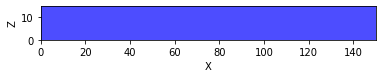

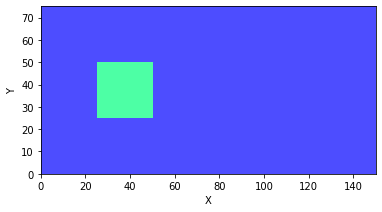

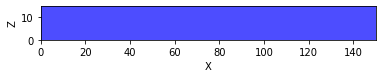

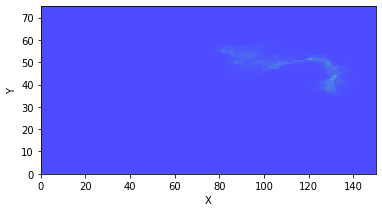

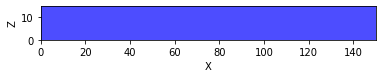

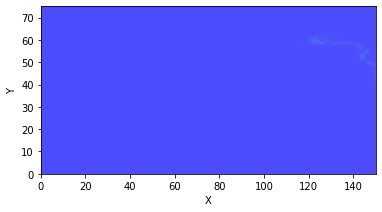

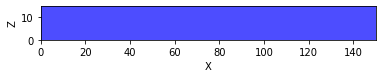

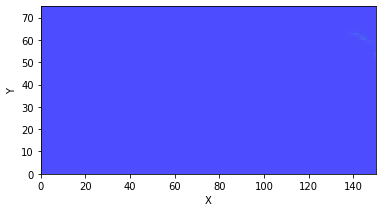

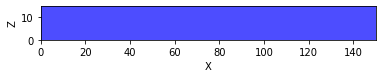

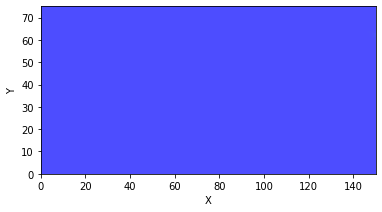

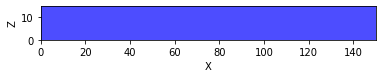

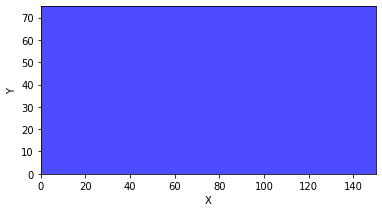

In [116]:
#Check data okay
c=bf.UcnFile('MT3D001.UCN')
for k in range(0,51,10):
    extent=(0., Lx, 0, Lz)
    concentration=c.get_data(totim=k)
    plt.subplot(1,1,1,aspect='equal')
    plt.imshow(concentration[:, 14, :],extent=extent, cmap=plt.get_cmap('winter'), alpha=0.7, origin='lower', vmin=0, vmax=1)
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.savefig('contamiant transport_'+str(k),dpi=400)
    plt.show()
    
    extent=(0., Lx, 0, Ly)
    plt.subplot(1,1,1,aspect='equal')
    plt.imshow(concentration[-1, :, :],extent=extent, cmap=plt.get_cmap('winter'), alpha=0.7, origin='lower', vmin=0, vmax=1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

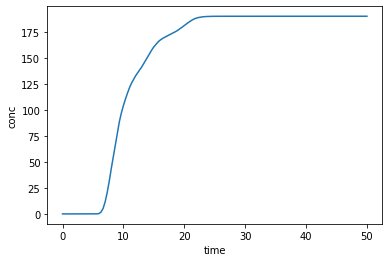

In [117]:
conc = np.zeros(len(c.get_times()))
init = np.sum(c.get_data(totim=0)[:,:,:lambdax*5])
cpc = 0

for k in range(len(c.get_times())):
    concentration=c.get_data(totim=c.get_times()[k])
    cpc += np.sum(concentration[:,:,lambdax*5])
    conc[k]=cpc
    
plt.plot(times, conc)
plt.xlabel('time')
plt.ylabel('conc')
plt.show()

In [118]:

wellgrid = np.zeros((lambdax*lambday, 3))
cpgrid = np.zeros((nlay*nrow, 3))

iteration = 0
deltal = 1
for l in range(nlay):
    for k in range(nrow):
        cpgrid[iteration] = np.array(([5*lambdax*deltal,k*deltal,l*deltal]))
        iteration += 1
iteration = 0        
for l in range(lambdax, lambdax*2):
    for k in range(lambday, lambday*2):
        wellgrid[iteration] = np.array(([l*deltal,k*deltal,(nlay-1)*deltal]))
        iteration += 1

In [120]:
point_cloud = pv.PolyData(vgrid)
point_cloud['vector'] = velocity_vector
point_cloud['conc0'] = c.get_data(totim=0).flatten()
point_cloud['conc1'] = c.get_data(totim=1).flatten()
point_cloud['conc10'] = c.get_data(totim=10).flatten()
point_cloud['conc20'] = c.get_data(totim=20).flatten()
point_cloud['conc30'] = c.get_data(totim=30).flatten()
point_cloud['conc40'] = c.get_data(totim=40).flatten()
point_cloud['conc50'] = c.get_data(totim=50).flatten()
wellgrid = pv.PolyData(wellgrid)
cpgrid = pv.PolyData(cpgrid)

point_cloud.save("vtk/mesh2.vtk")
wellgrid.save("vtk/wellgrid2.vtk")
cpgrid.save("vtk/cpgrid2.vtk")

In [23]:
point_cloud

PolyData (0x1f7214762e8)
  N Cells:	168750
  N Points:	168750
  X Bounds:	0.000e+00, 1.490e+02
  Y Bounds:	0.000e+00, 7.400e+01
  Z Bounds:	0.000e+00, 1.400e+01
  N Arrays:	8

In [24]:
wellgrid

PolyData,Information
N Cells,625
N Points,625
X Bounds,"2.500e+01, 4.900e+01"
Y Bounds,"2.500e+01, 4.900e+01"
Z Bounds,"1.400e+01, 1.400e+01"
N Arrays,0


In [25]:
cpgrid

PolyData,Information
N Cells,1125
N Points,1125
X Bounds,"1.250e+02, 1.250e+02"
Y Bounds,"0.000e+00, 7.400e+01"
Z Bounds,"0.000e+00, 1.400e+01"
N Arrays,0
